# Challenge Set 1  
Topic:        Explore MTA turnstile data  
Date:         04/18/2016  
Name:         David Kanarek  
Worked with:  Max, Brian  

**Challenge 1**

In [2]:
import csv
import re
from collections import defaultdict
from itertools import islice
from datetime import date
from datetime import datetime
from datetime import time


def makeTurnstyleDict(filename):
    '''take a .csv file of mta data and return a dictionary with each CA, unit, SCP, station as the key'''
    turnstyle_dict = defaultdict(list)
    dt = []
    entries_list = []
    key_list = []


    with open(filename,'r') as f:
        reader = csv.reader(f)
        reader.next() # skip header row
        for row in reader:
            C_A = row[0]
            unit = row[1]
            SCP = row[2]
            station = row[3]
            row[-1]=row[-1].strip()
            entries_list.append(int(row[9]))

            key = (C_A, unit,SCP,station)
            key_list.append(key)

            d = row[6].split('/') #date split into month, day, and year
            t = row[7].split(':') #time split into hour, minute, second

            for i in range(len(d)):  #convert date and time from strings to ints
                d[i]=int(d[i])
                t[i]= int(t[i])

            dt.append(datetime.combine(date(d[2],d[0],d[1]),time(t[0],t[1],t[2]))) #datetime object

            if key in turnstyle_dict:
                turnstyle_dict[key].append(row[4:])
            else:
                turnstyle_dict[key]=row[4:]
    
    return turnstyle_dict, dt, entries_list, key_list    

turnstyle_dict,dt,entries_list,key_list = makeTurnstyleDict('turnstyle_data_may30_2015_2.csv')


**Challenge 2**

In [18]:
def cleanTurnstyleDict(turnstyle_dict,dt,entries_list,key_list):

    turnstyle_clean = defaultdict(list)

    count = 0
    day = dt[0].day
    indices = [0]
    total = 0       #list of lists for number of entries per 4 hour block
    while count < len(key_list):       

        if key_list[count] in turnstyle_clean:
            if (entries_list[count]-total) >=0 and (entries_list[count]-total) < 10000:
                turnstyle_clean[key_list[count]].append([dt[count],entries_list[count]-total]) 
            total = entries_list[count]     #cumulative total of entries
        else:
            turnstyle_clean[key_list[count]] = [[dt[count],0]]
            total = entries_list[count]

        if dt[count].day != day:             #locate range of indices for each day
            indices.append(count)
            day = dt[count].day

        count +=1

    return turnstyle_clean, indices

turnstyle_clean, indices = cleanTurnstyleDict(turnstyle_dict,dt,entries_list,key_list)
for i in turnstyle_clean.keys()[0:1]:
    print i, turnstyle_clean[i]

('A030', 'R083', '01-06-00', '23 ST-5 AVE') [[datetime.datetime(2015, 5, 23, 0, 0), 0], [datetime.datetime(2015, 5, 23, 4, 0), 56], [datetime.datetime(2015, 5, 23, 8, 0), 26], [datetime.datetime(2015, 5, 23, 12, 0), 101], [datetime.datetime(2015, 5, 23, 16, 0), 214], [datetime.datetime(2015, 5, 23, 20, 0), 244], [datetime.datetime(2015, 5, 24, 0, 0), 174], [datetime.datetime(2015, 5, 24, 4, 0), 53], [datetime.datetime(2015, 5, 24, 8, 0), 27], [datetime.datetime(2015, 5, 24, 12, 0), 70], [datetime.datetime(2015, 5, 24, 16, 0), 182], [datetime.datetime(2015, 5, 24, 20, 0), 227], [datetime.datetime(2015, 5, 25, 0, 0), 141], [datetime.datetime(2015, 5, 25, 4, 0), 18], [datetime.datetime(2015, 5, 25, 8, 0), 18], [datetime.datetime(2015, 5, 25, 12, 0), 73], [datetime.datetime(2015, 5, 25, 16, 0), 144], [datetime.datetime(2015, 5, 25, 20, 0), 223], [datetime.datetime(2015, 5, 26, 0, 0), 138], [datetime.datetime(2015, 5, 26, 4, 0), 17], [datetime.datetime(2015, 5, 26, 8, 0), 103], [datetime.da

**Challenge 3**

In [19]:
def turnstyleDailyTotal(turnstyle_clean,indices):
    turnstyle_total =defaultdict(list)
    day_start= indices[0]
    count = 1


    while day_start < indices[len(indices)-1]:
        day_end = indices[count]
        daily_total = entries_list[day_end]-entries_list[day_start]   #total entries in the day is entries at the end - entries at the start

        if key_list[day_end] != key_list[day_start]:
            daily_total = int(1.2*(entries_list[day_end-1]-entries_list[day_start]))

        if key_list[day_start] in turnstyle_total:      #add dictionarty entries for each day at each station
            d = dt[day_start]
            turnstyle_total[key_list[day_start]].append([date(d.year,d.month,d.day),daily_total]) 
        else:
            d = dt[day_start]
            turnstyle_total[key_list[day_start]] = [[date(d.year,d.month,d.day),daily_total]]

        day_start=day_end
        count+=1
    
    return turnstyle_total

turnstyle_total = turnstyleDailyTotal(turnstyle_clean, indices)

for i in key_list[0:1]:
    print i, turnstyle_total[i]

    

('A002', 'R051', '02-00-00', 'LEXINGTON AVE') [[datetime.date(2015, 5, 23), 1087], [datetime.date(2015, 5, 24), 732], [datetime.date(2015, 5, 25), 854], [datetime.date(2015, 5, 26), 1831], [datetime.date(2015, 5, 27), 1817], [datetime.date(2015, 5, 28), 1823], [datetime.date(2015, 5, 29), 1900]]


**Convert to Pandas**

In [4]:
import pandas as pd
import matplotlib as plt
import numpy as np
import datetime as dt

may3015 = pd.read_csv('turnstyle_data_may30_2015_2.csv')
may3015.columns = map(str.strip,may3015.columns.values)
may3015['DATE']= pd.to_datetime(may3015['DATE'],format = '%m/%d/%Y')

may3015.head()


,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS
0,A002,R051,02-00-00,LEXINGTON AVE,NQR456,BMT,2015-05-23,00:00:00,REGULAR,5149653,1743036
1,A002,R051,02-00-00,LEXINGTON AVE,NQR456,BMT,2015-05-23,04:00:00,REGULAR,5149687,1743046
2,A002,R051,02-00-00,LEXINGTON AVE,NQR456,BMT,2015-05-23,08:00:00,REGULAR,5149708,1743066
3,A002,R051,02-00-00,LEXINGTON AVE,NQR456,BMT,2015-05-23,12:00:00,REGULAR,5149852,1743152
4,A002,R051,02-00-00,LEXINGTON AVE,NQR456,BMT,2015-05-23,16:00:00,REGULAR,5150097,1743229


In [5]:
may3015[['ENTRIES','EXITS']]= may3015.groupby(['STATION','C/A','UNIT','SCP'])[['ENTRIES','EXITS']].diff()
may3015 = may3015.dropna(how = 'any', axis = 0)


In [6]:

#may3015['ENTRIES'] = may3015[may3015['ENTRIES'] > 50]
may3015 = may3015[(may3015['ENTRIES'] >= 0 ) & (may3015['ENTRIES'] < 14400)]
may3015 = may3015[(may3015['EXITS'] >= 0 ) & (may3015['EXITS'] < 14400)]
may3015.head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS
1,A002,R051,02-00-00,LEXINGTON AVE,NQR456,BMT,2015-05-23,04:00:00,REGULAR,34,10
2,A002,R051,02-00-00,LEXINGTON AVE,NQR456,BMT,2015-05-23,08:00:00,REGULAR,21,20
3,A002,R051,02-00-00,LEXINGTON AVE,NQR456,BMT,2015-05-23,12:00:00,REGULAR,144,86
4,A002,R051,02-00-00,LEXINGTON AVE,NQR456,BMT,2015-05-23,16:00:00,REGULAR,245,77
5,A002,R051,02-00-00,LEXINGTON AVE,NQR456,BMT,2015-05-23,20:00:00,REGULAR,375,63


In [7]:
#may3015[['ENTRIES','EXITS']]= 
df = may3015.groupby(['STATION','C/A','UNIT','SCP','DATE'])[['ENTRIES','EXITS']].sum().reset_index()
df.head()
#print df.columns.values

,STATION,C/A,UNIT,SCP,DATE,ENTRIES,EXITS
0,1 AVE,H007,R248,00-00-00,2015-05-23,1650,2471
1,1 AVE,H007,R248,00-00-00,2015-05-24,2184,3152
2,1 AVE,H007,R248,00-00-00,2015-05-25,1990,3079
3,1 AVE,H007,R248,00-00-00,2015-05-26,4012,4584
4,1 AVE,H007,R248,00-00-00,2015-05-27,4457,4442


**Challenge 4**

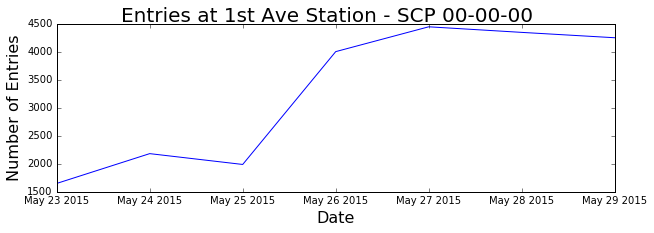

In [30]:
%matplotlib inline
import matplotlib.pyplot as plt

dates = list(df['DATE'])
counts = list(df['ENTRIES'])

plt.figure(figsize=(10,3))
plt.plot(dates[:7],counts[:7])

plt.suptitle('Entries at 1st Ave Station - SCP 00-00-00', fontsize=20)
plt.xlabel('Date', fontsize=16)
plt.ylabel('Number of Entries', fontsize=16)

**Challenge 5**

In [31]:
sum_turnstyles = df.groupby(['STATION','C/A','UNIT','DATE'])[['ENTRIES','EXITS']].sum().reset_index()
sum_turnstyles.head()

,STATION,C/A,UNIT,DATE,ENTRIES,EXITS
0,1 AVE,H007,R248,2015-05-23,5154,4938
1,1 AVE,H007,R248,2015-05-24,6676,6267
2,1 AVE,H007,R248,2015-05-25,6055,5856
3,1 AVE,H007,R248,2015-05-26,12839,8487
4,1 AVE,H007,R248,2015-05-27,14099,8411


**Challenge 6**

In [25]:
station_sum = sum_turnstyles.groupby(['STATION','DATE'])[['ENTRIES','EXITS']].sum().reset_index()
station_sum.head()

,STATION,DATE,ENTRIES,EXITS
0,1 AVE,2015-05-23,10588,11975
1,1 AVE,2015-05-24,13775,14731
2,1 AVE,2015-05-25,12505,14041
3,1 AVE,2015-05-26,22049,23737
4,1 AVE,2015-05-27,24283,24784


**Challenge 7**

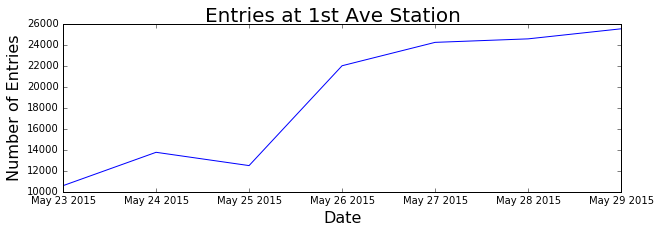

In [29]:
dates = list(station_sum['DATE'])
counts = list(station_sum['ENTRIES'])

plt.figure(figsize=(10,3))
plt.plot(dates[:7],counts[:7])

plt.suptitle('Entries at 1st Ave Station', fontsize=20)
plt.xlabel('Date', fontsize=16)
plt.ylabel('Number of Entries', fontsize=16)

**Challenge 8**

In [27]:
urls = [
        'http://web.mta.info/developers/data/nyct/turnstile/turnstile_150523.txt',
        'http://web.mta.info/developers/data/nyct/turnstile/turnstile_150516.txt',
        'http://web.mta.info/developers/data/nyct/turnstile/turnstile_150509.txt'
       ]

csvs = ['turnstyle_data_may23_2015.csv','turnstyle_data_may16_2015.csv','turnstyle_data_may09_2015.csv']


def clean_df(df):
    df.columns = map(str.strip,df.columns.values)
    df['DATE']= pd.to_datetime(df['DATE'],format = '%m/%d/%Y')
    return df
    
def get_diffs(df):
    df[['ENTRIES','EXITS']]= df.groupby(['STATION','C/A','UNIT','SCP'])[['ENTRIES','EXITS']].diff()
    df = df.dropna(how = 'any', axis = 0)
    df = df[(df['ENTRIES'] >= 0 ) & (df['ENTRIES'] < 14400)]
    df = df[(df['EXITS'] >= 0 ) & (df['EXITS'] < 14400)]
    return df

def get_weekly_sum(df):
    return df.groupby(['STATION','DATE'])[['ENTRIES','EXITS']].sum().reset_index()
   
def station_sums(df, week):
    df = clean_df(df)
    df = get_diffs(df)
    df = get_weekly_sum(df)
    df['WEEK_ENDING'] = pd.Series(week*df.shape[0])
    return df
    
def append_weeks(multi_week_sum,urls):
    
    for i in urls:
        x = pd.read_csv(i)
        x = clean_df(x)
        x = get_diffs(x)
        x = get_weekly_sum(x)
        s = [i[-10:-4]]*t.shape[0]
        x['WEEK_ENDING']=pd.Series(s)
        multi_week_sum.append(x)
   
    return multi_week_sum
        
t = get_weekly_sum(sum_turnstyles)
s = ['20150530']*t.shape[0]
t['WEEK_ENDING']=pd.Series(s)


In [28]:
may2315 = station_sums(pd.read_csv(csvs[0]),['20150523'])
may1615 = station_sums(pd.read_csv(csvs[1]),['20150516'])
may0915 = station_sums(pd.read_csv(csvs[2]),['20150509'])

four_week_total = t.append(may2315.append(may1615.append(may0915)))



**Challenge 9**

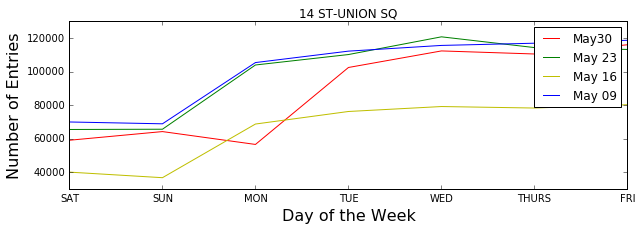

In [32]:
m = four_week_total[(four_week_total['STATION'] == '14 ST-UNION SQ' )]
week_ends = ['20150530','20150523','20150516','20150509']

dates = ['SAT','SUN','MON','TUE','WED','THURS','FRI']
entries = []
for i in week_ends:
    entries.append(list(m[(m['WEEK_ENDING'] == i )]['ENTRIES']))

x = range(1,8)

plt.figure(figsize=(10,3))
plt.title('14 ST-UNION SQ')
plt.xticks(x,dates)

plt.plot(x, entries[0],'r', label = 'May30')
         #x, entries[1],'g', x, entries[2],'y', x, entries[3], 'b')
plt.plot(x, entries[1],'g', label = 'May 23')
plt.plot(x, entries[2],'y', label = 'May 16')
plt.plot(x, entries[3],'b', label = 'May 09')
plt.xlabel('Day of the Week', fontsize=16)
plt.ylabel('Number of Entries', fontsize=16)
plt.legend()

**Challenge 10**

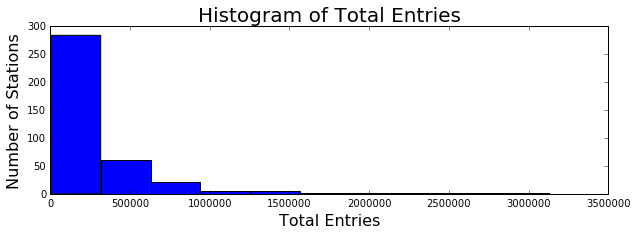

In [36]:
total_ridership = four_week_total.groupby(['STATION'])[['STATION','ENTRIES']].sum().reset_index()

tr  = list(total_ridership['ENTRIES'])
plt.figure(figsize=(10,3))
plt.hist(tr)
plt.title('Histogram of Total Entries', fontsize = 20)
plt.xlabel('Total Entries', fontsize=16)
plt.ylabel('Number of Stations', fontsize=16)


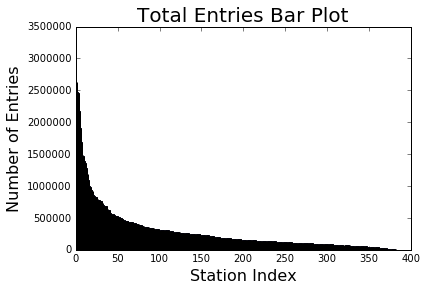

In [39]:
tr = sorted(tr, reverse = True)

indices = range(len(tr))
plt.bar(indices, tr)

plt.title('Total Entries Bar Plot', fontsize = 20)
plt.xlabel('Station Index', fontsize=16)
plt.ylabel('Number of Entries', fontsize=16)